In [1]:
import os
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


In [2]:
@dataclass(frozen=True)
class CFG:
    data_path: Path = Path("Datathon/DATA/Spaced Repetition Data")
    figure_dpi: int = 150
    k_range_iter: range = range(2, 11)
    random_state: int = 42
    gbtm_max_patients: int = 200_000
    kproto_max_patients: int = 150_000
    ssa_max_patients: int = 150_000
    preview_nrows: int = 500_000
    max_rows_for_plots: int = 1_000_000
    min_group_size: int = 30


cfg = CFG()

np.random.seed(cfg.random_state)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


In [3]:
# ── Anthropic-inspired warm theme ──────────────────────────────────────
plt.rcParams.update({
    "figure.dpi": cfg.figure_dpi,
    "figure.facecolor": "#FDF8F4",
    "axes.facecolor": "#FDF8F4",
    "savefig.facecolor": "#FDF8F4",
    "font.family": "sans-serif",
    "font.sans-serif": ["Segoe UI", "Helvetica Neue", "Arial", "sans-serif"],
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
    "axes.grid": True,
    "grid.color": "#E8DDD4",
    "grid.linewidth": 0.8,
    "grid.alpha": 0.7,
    "axes.labelcolor": "#8A7E74",
    "axes.titlesize": 14,
    "axes.titleweight": "600",
    "axes.titlecolor": "#3D3229",
    "xtick.color": "#8A7E74",
    "ytick.color": "#8A7E74",
    "xtick.major.size": 0,
    "ytick.major.size": 0,
    "text.color": "#3D3229",
    "legend.frameon": False,
})

print(f"Config: data_path={cfg.data_path}")
print(f"  k_range={list(cfg.k_range_iter)}, random_state={cfg.random_state}")
print(f"  gbtm_max={cfg.gbtm_max_patients:,}, kproto_max={cfg.kproto_max_patients:,}, ssa_max={cfg.ssa_max_patients:,}")


Config: data_path=Datathon/DATA/Spaced Repetition Data
  k_range=[2, 3, 4, 5, 6, 7, 8, 9, 10], random_state=42
  gbtm_max=200,000, kproto_max=150,000, ssa_max=150,000


In [4]:
def resolve_data_target(path_like: Path) -> Path:
    candidates = [
        path_like,
        Path.cwd() / path_like,
        Path.home() / path_like,
        Path.home() / "Documents" / path_like,
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"Could not resolve data path '{path_like}'. Checked: "
        + ", ".join(str(c) for c in candidates)
    )


def list_data_files(target: Path) -> List[Path]:
    if target.is_file():
        return [target]
    files = [p for p in sorted(target.iterdir()) if p.is_file() and not p.name.startswith(".")]
    if not files:
        raise FileNotFoundError(f"No readable files found in directory: {target}")
    return files


def load_table(path: Path) -> pd.DataFrame:
    suffix = path.suffix.lower()
    try:
        if suffix == ".parquet":
            return pd.read_parquet(path)
        if suffix == ".feather":
            return pd.read_feather(path)
        if suffix in {".pkl", ".pickle"}:
            return pd.read_pickle(path)
        if suffix in {".xlsx", ".xls"}:
            return pd.read_excel(path)
        if suffix == ".json":
            try:
                return pd.read_json(path, lines=True)
            except ValueError:
                return pd.read_json(path)
        if suffix == ".tsv":
            return pd.read_csv(path, sep="	", low_memory=False)
        if suffix == ".txt":
            return pd.read_csv(path, sep=None, engine="python", low_memory=False)
        return pd.read_csv(path, low_memory=False)
    except MemoryError:
        print(f"MemoryError for {path.name}. Falling back to first {cfg.preview_nrows:,} rows.")
        if suffix == ".tsv":
            return pd.read_csv(path, sep="	", low_memory=False, nrows=cfg.preview_nrows)
        if suffix == ".txt":
            return pd.read_csv(path, sep=None, engine="python", low_memory=False, nrows=cfg.preview_nrows)
        return pd.read_csv(path, low_memory=False, nrows=cfg.preview_nrows)


data_target = resolve_data_target(cfg.data_path)
file_paths = list_data_files(data_target)

print(f"Resolved data target: {data_target}")
print(f"Files discovered: {len(file_paths)}")

tables: Dict[str, pd.DataFrame] = {}
for fp in file_paths:
    table_name = fp.stem if fp.stem else fp.name
    print(f"\nLoading: {fp.name}")
    df_loaded = load_table(fp)
    tables[table_name] = df_loaded

    print(f"Shape: {df_loaded.shape}")
    print("Columns and dtypes:")
    display(pd.DataFrame({"column": df_loaded.columns, "dtype": df_loaded.dtypes.astype(str)}))

    print("First 5 rows:")
    display(df_loaded.head(5))

dataset_shapes = {name: frame.shape for name, frame in tables.items()}
print("\nDataset shapes summary:")
for name, shape in dataset_shapes.items():
    print(f"- {name}: {shape}")

primary_table_name = max(tables.keys(), key=lambda k: len(tables[k]))
df = tables[primary_table_name].copy()
print(f"\nPrimary analysis table: {primary_table_name} ({df.shape[0]:,} rows, {df.shape[1]} columns)")


Resolved data target: /Users/bouns/Documents/Datathon/DATA/Spaced Repetition Data
Files discovered: 1

Loading: Spaced Repetition Data
Shape: (12854226, 12)
Columns and dtypes:


,column,dtype
p_recall,p_recall,float64
timestamp,timestamp,int64
delta,delta,int64
user_id,user_id,object
learning_language,learning_language,object
ui_language,ui_language,object
lexeme_id,lexeme_id,object
lexeme_string,lexeme_string,object
history_seen,history_seen,int64
history_correct,history_correct,int64


First 5 rows:


,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1



Dataset shapes summary:
- Spaced Repetition Data: (12854226, 12)

Primary analysis table: Spaced Repetition Data (12,854,226 rows, 12 columns)


## EDA Scope
This notebook performs a reproducible, event-level exploratory analysis of spaced repetition behavior. It includes data quality checks, distributional diagnostics, temporal dynamics, user/item heterogeneity, and interaction analyses aligned with thesis-grade reporting.

The largest loaded table is treated as the primary event log (`df`).


In [5]:
def infer_column(columns: pd.Index, patterns: List[str], blocked: Optional[Set[str]] = None) -> Optional[str]:
    blocked = blocked or set()
    for col in columns:
        if col in blocked:
            continue
        low = col.lower()
        if any(re.search(pat, low) for pat in patterns):
            return col
    return None


schema = {
    "user_col": "user_id" if "user_id" in df.columns else infer_column(df.columns, [r"user", r"student", r"learner", r"uid"]),
    "item_col": "lexeme_id" if "lexeme_id" in df.columns else infer_column(df.columns, [r"lexeme", r"item", r"card", r"question", r"token"]),
    "time_col": "timestamp" if "timestamp" in df.columns else infer_column(df.columns, [r"timestamp", r"time", r"date", r"datetime", r"ts"]),
    "prob_col": "p_recall" if "p_recall" in df.columns else infer_column(df.columns, [r"recall", r"outcome", r"success", r"accuracy", r"correct"]),
    "interval_col": "delta" if "delta" in df.columns else infer_column(df.columns, [r"delta", r"interval", r"lag", r"elapsed"]),
    "learn_lang_col": "learning_language" if "learning_language" in df.columns else infer_column(df.columns, [r"learning_language", r"learn.*lang", r"target.*lang", r"language"]),
    "ui_lang_col": "ui_language" if "ui_language" in df.columns else infer_column(df.columns, [r"ui_language", r"interface.*lang", r"ui.*lang"]),
}


def parse_event_time(series: pd.Series) -> pd.Series:
    if pd.api.types.is_datetime64_any_dtype(series):
        parsed = pd.to_datetime(series, errors="coerce", utc=True)
        return parsed.dt.tz_convert(None)

    as_num = pd.to_numeric(series, errors="coerce")
    if as_num.notna().mean() > 0.80:
        median_value = as_num.dropna().median()
        if median_value > 1e14:
            unit = "ns"
        elif median_value > 1e11:
            unit = "ms"
        else:
            unit = "s"
        parsed = pd.to_datetime(as_num, unit=unit, errors="coerce", utc=True)
        return parsed.dt.tz_convert(None)

    parsed = pd.to_datetime(series, errors="coerce", utc=True)
    return parsed.dt.tz_convert(None)


if schema["time_col"] is not None:
    df["_event_time"] = parse_event_time(df[schema["time_col"]])
    df["_event_date"] = df["_event_time"].dt.date
    df["_event_hour"] = df["_event_time"].dt.hour
    df["_event_dow"] = df["_event_time"].dt.day_name()

if {"history_correct", "history_seen"}.issubset(df.columns):
    denom = pd.to_numeric(df["history_seen"], errors="coerce").replace(0, np.nan)
    numer = pd.to_numeric(df["history_correct"], errors="coerce")
    df["history_acc"] = numer / denom

if {"session_correct", "session_seen"}.issubset(df.columns):
    denom = pd.to_numeric(df["session_seen"], errors="coerce").replace(0, np.nan)
    numer = pd.to_numeric(df["session_correct"], errors="coerce")
    df["session_acc"] = numer / denom

if schema["interval_col"] is not None:
    interval_num = pd.to_numeric(df[schema["interval_col"]], errors="coerce")
    df["log_interval"] = np.log1p(interval_num.clip(lower=0))

schema_overview = pd.DataFrame({"role": list(schema.keys()), "column": list(schema.values())})
print("Inferred schema:")
display(schema_overview)

memory_mb = df.memory_usage(deep=True).sum() / 1024**2
print(f"Working table memory footprint: {memory_mb:,.2f} MB")


Inferred schema:


,role,column
0,user_col,user_id
1,item_col,lexeme_id
2,time_col,timestamp
3,prob_col,p_recall
4,interval_col,delta
5,learn_lang_col,learning_language
6,ui_lang_col,ui_language


Working table memory footprint: 6,771.05 MB


## Missing Values Analysis
Missingness is profiled both in counts and percentages to identify potential non-random gaps that can bias downstream trajectory, clustering, or survival-style analyses.


In [6]:
missing_count = df.isna().sum()
missing_pct = (missing_count / len(df) * 100).round(3)
missing_table = (
    pd.DataFrame({"missing_n": missing_count, "missing_pct": missing_pct})
    .sort_values(["missing_n", "missing_pct"], ascending=False)
)

print("Top missingness columns:")
display(missing_table.head(25))

missing_nonzero = missing_table[missing_table["missing_n"] > 0].head(20)
if not missing_nonzero.empty:
    plt.figure(figsize=(10, max(4, 0.35 * len(missing_nonzero))))
    sns.barplot(
        data=missing_nonzero.reset_index(),
        x="missing_pct",
        y="index",
        color="#C17C3A",
    )
    plt.title("Missingness Rate by Column")
    plt.xlabel("Missing (%)")
    plt.ylabel("Column")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values detected.")


Top missingness columns:


,missing_n,missing_pct
p_recall,0,0.0
timestamp,0,0.0
delta,0,0.0
user_id,0,0.0
learning_language,0,0.0
ui_language,0,0.0
lexeme_id,0,0.0
lexeme_string,0,0.0
history_seen,0,0.0
history_correct,0,0.0


No missing values detected.


## Summary Statistics
Numeric and categorical summaries are reported with robust percentiles and cardinality diagnostics. This supports quick detection of skew, sparsity, and extreme values.


In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
object_cols = df.select_dtypes(include=["object", "category", "string"]).columns.tolist()

if numeric_cols:
    numeric_summary = df[numeric_cols].describe(
        percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    ).T
    numeric_summary["iqr"] = numeric_summary["75%"] - numeric_summary["25%"]
    numeric_summary["cv"] = numeric_summary["std"] / numeric_summary["mean"].replace(0, np.nan)
    print("Numeric summary:")
    display(numeric_summary.sort_values("count", ascending=False))

if object_cols:
    cat_rows = []
    for col in object_cols:
        vc = df[col].value_counts(dropna=True)
        top_value = vc.index[0] if len(vc) else np.nan
        top_freq = int(vc.iloc[0]) if len(vc) else 0
        cat_rows.append(
            {
                "column": col,
                "n_unique": int(df[col].nunique(dropna=True)),
                "missing_pct": float(df[col].isna().mean() * 100),
                "top_value": top_value,
                "top_freq": top_freq,
            }
        )
    cat_summary = pd.DataFrame(cat_rows).sort_values("n_unique", ascending=False)
    print("Categorical summary:")
    display(cat_summary)


Numeric summary:


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,iqr,cv
p_recall,12854226.0,8.961056e-01,2.714048e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.302872
timestamp,12854226.0,1.362589e+09,2.932082e+05,1.362076e+09,1.362089e+09,1.362129e+09,1.362343e+09,1.362591e+09,1.362846e+09,1.363046e+09,1.363096e+09,1.363105e+09,502909.000000,0.000215
delta,12854226.0,7.295811e+05,2.246499e+06,1.000000e+00,8.900000e+01,1.570000e+02,5.320000e+02,7.713400e+04,4.425070e+05,3.498098e+06,1.134224e+07,4.032836e+07,441975.000000,3.079163
history_seen,12854226.0,2.198109e+01,1.295508e+02,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00,1.500000e+01,6.500000e+01,2.370000e+02,1.351800e+04,12.000000,5.893741
history_correct,12854226.0,1.935025e+01,1.119681e+02,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,6.000000e+00,1.300000e+01,5.800000e+01,2.080000e+02,1.288800e+04,10.000000,5.786389
session_seen,12854226.0,1.817686e+00,1.360180e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,7.000000e+00,2.000000e+01,1.000000,0.748303
session_correct,12854226.0,1.644134e+00,1.318794e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,6.000000e+00,2.000000e+01,1.000000,0.802120
_event_hour,12854226.0,1.264850e+01,7.499397e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1.400000e+01,1.900000e+01,2.300000e+01,2.300000e+01,2.300000e+01,14.000000,0.592908
history_acc,12854226.0,9.005919e-01,1.363249e-01,4.545455e-02,5.000000e-01,6.190476e-01,8.333333e-01,9.642857e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.166667,0.151373
session_acc,12854226.0,8.961056e-01,2.714048e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.302872


Categorical summary:


,column,n_unique,missing_pct,top_value,top_freq
0,user_id,115222,0.0,u:bcH_,19194
3,lexeme_id,19279,0.0,827a8ecb89f9b59ac5c29b620a5d3ed6,123099
4,lexeme_string,18781,0.0,a/a<det><ind><sg>,123099
5,_event_date,13,0.0,2013-03-06,1185491
6,_event_dow,7,0.0,Monday,2189938
1,learning_language,6,0.0,en,5014791
2,ui_language,4,0.0,en,7839435


## Distributional Diagnostics
This section examines marginal distributions for key numerical variables and high-level category prevalence. Heavy tails are clipped at extreme quantiles for readability in plots while preserving the full-data summaries above.


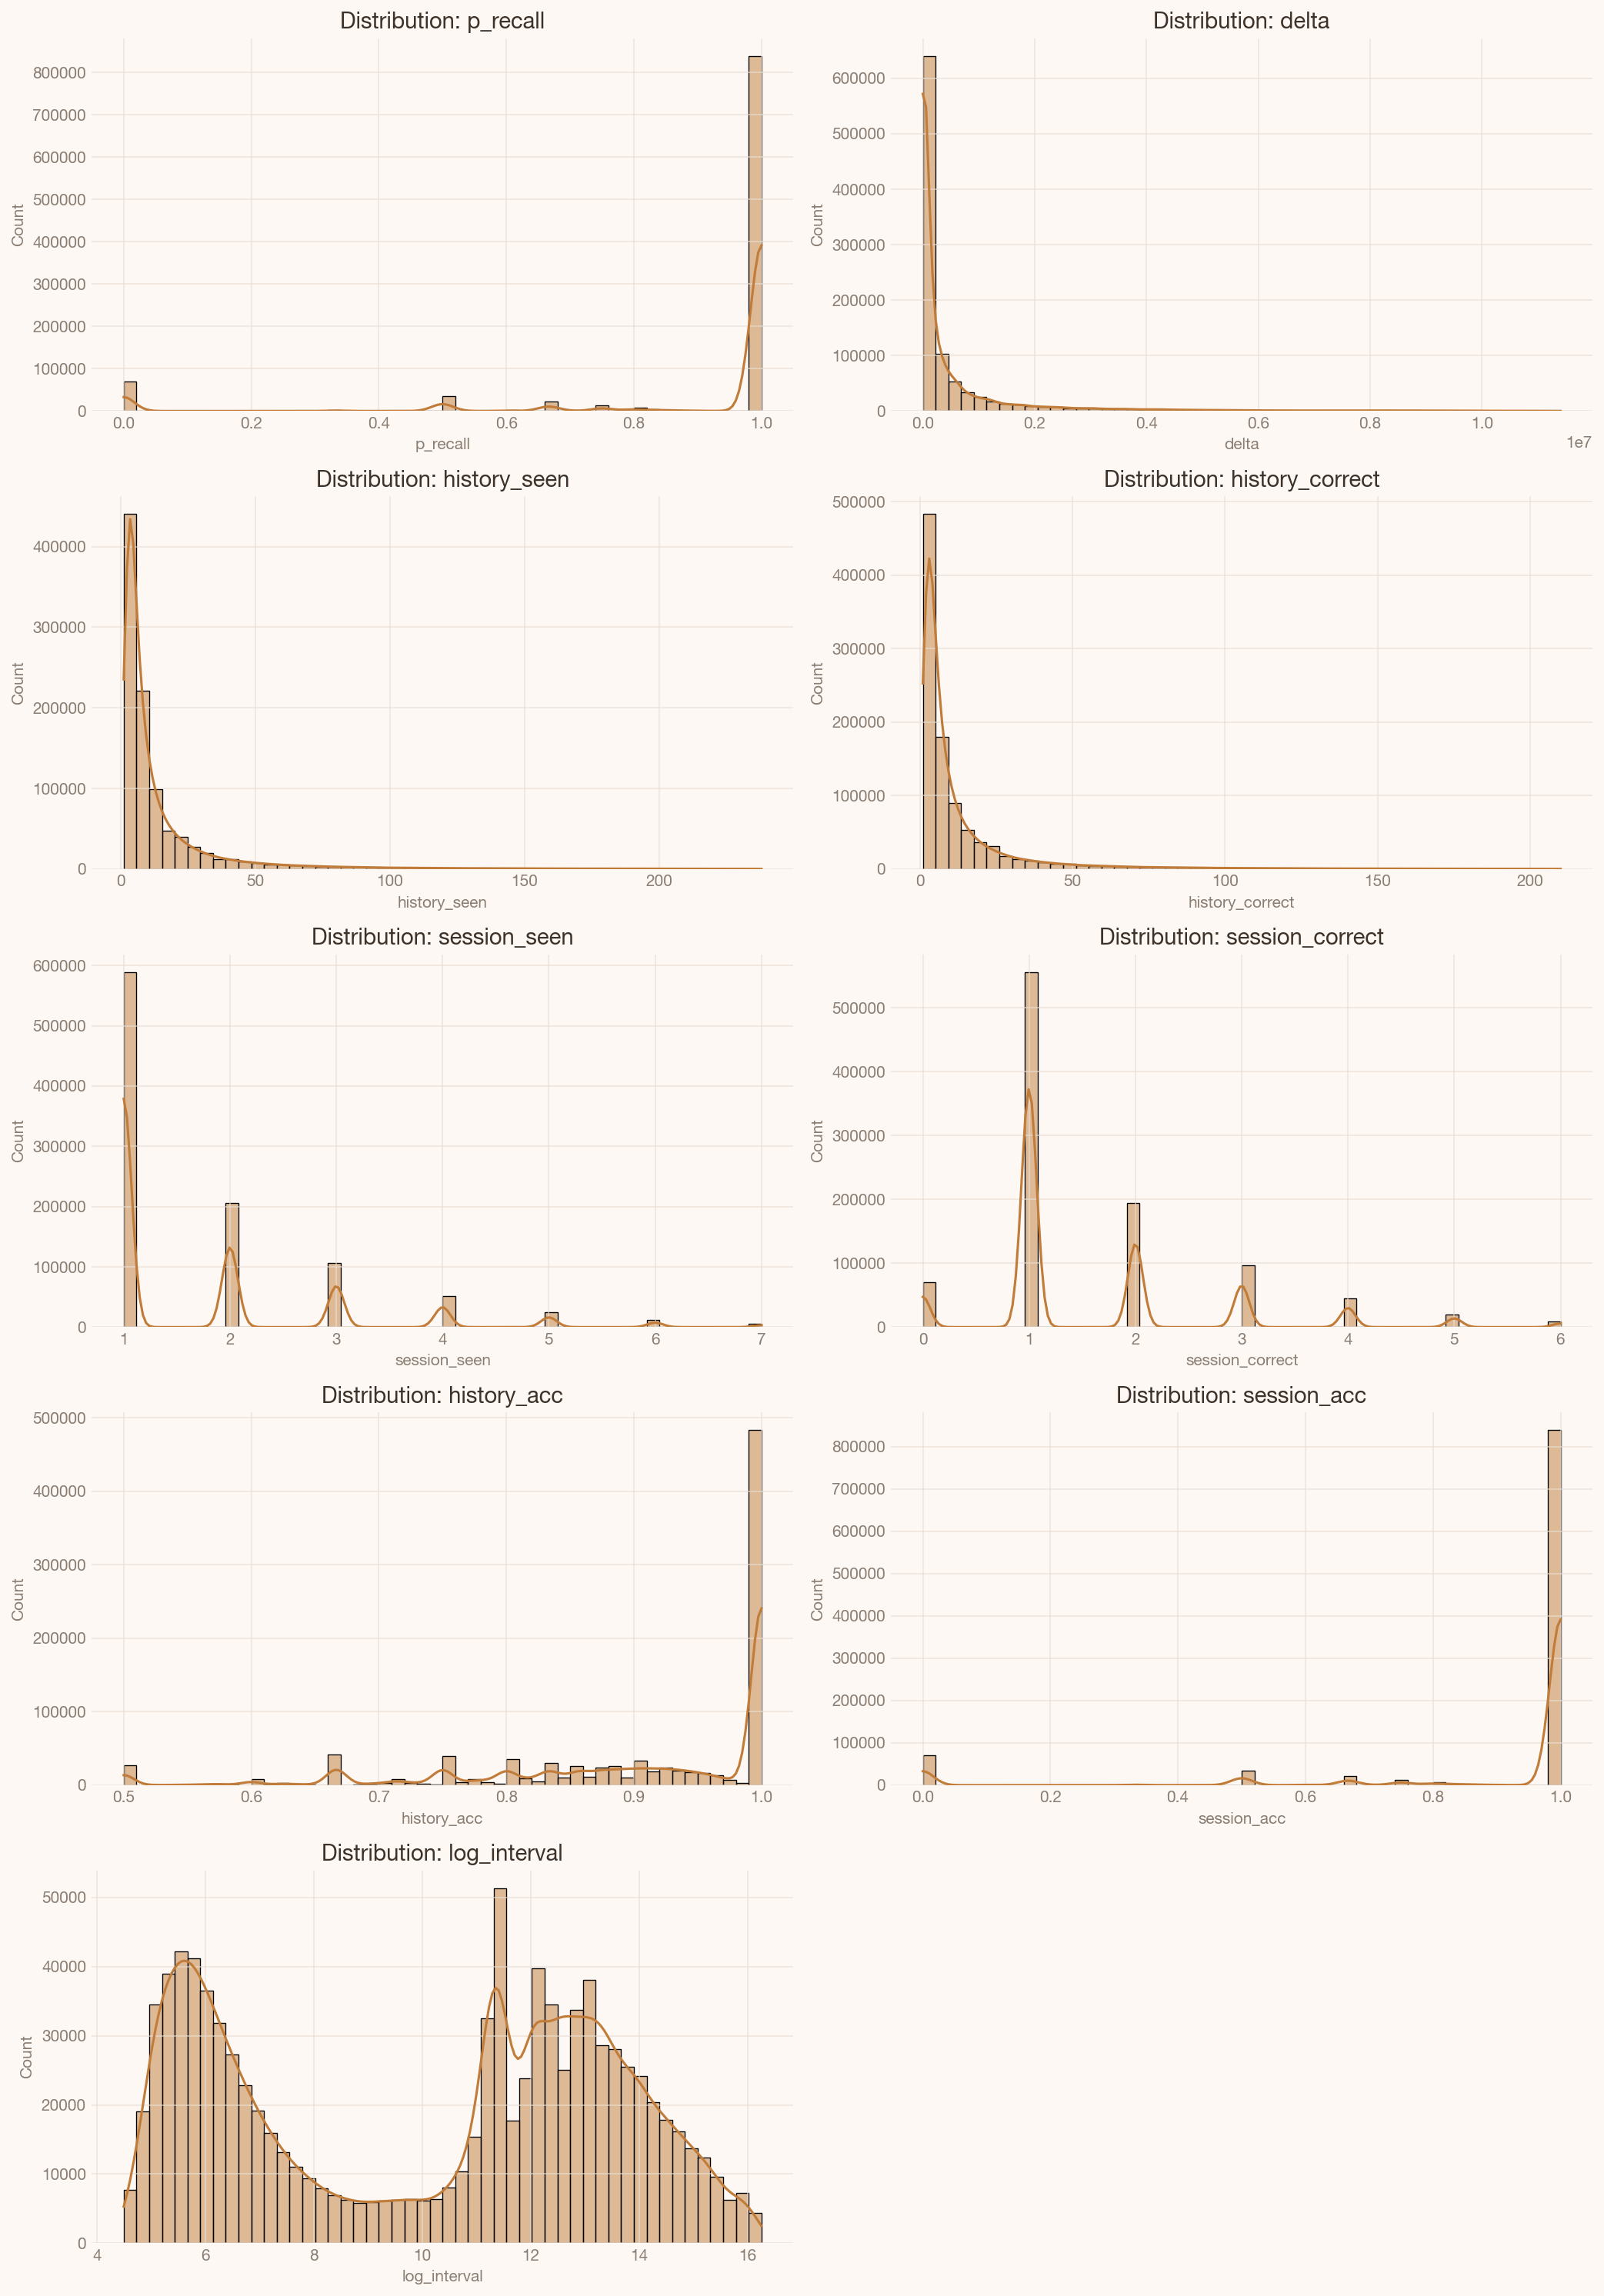

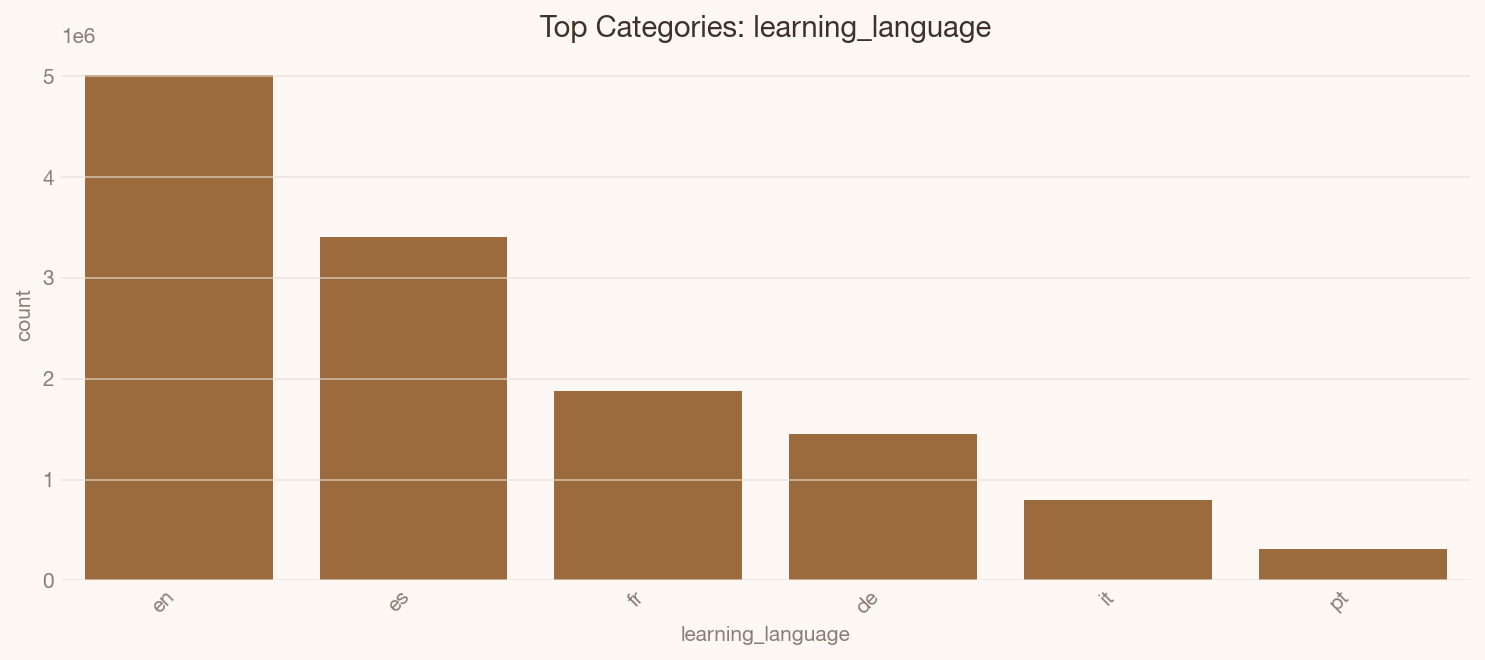

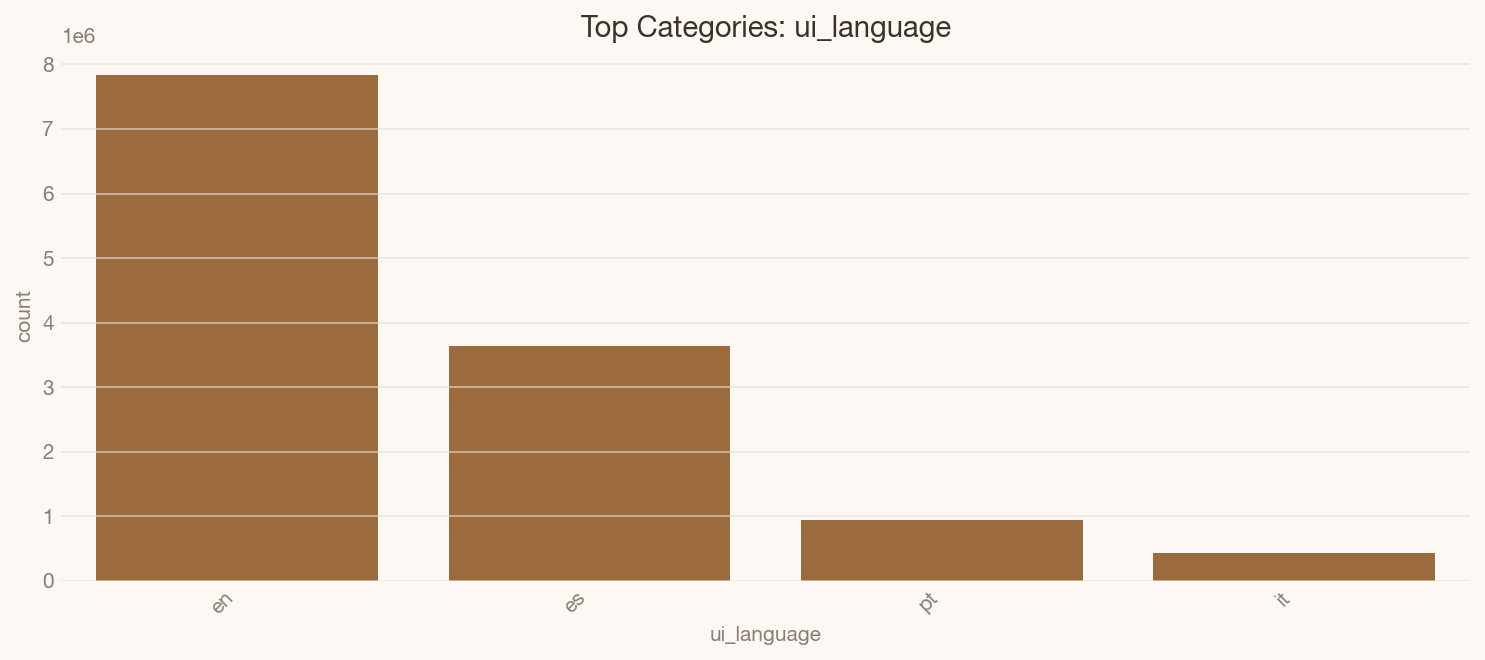

In [8]:
plot_df = df
if len(df) > cfg.max_rows_for_plots:
    plot_df = df.sample(cfg.max_rows_for_plots, random_state=cfg.random_state)

priority_numeric = [
    "p_recall",
    "delta",
    "history_seen",
    "history_correct",
    "session_seen",
    "session_correct",
    "history_acc",
    "session_acc",
    "log_interval",
]

dist_cols = [c for c in priority_numeric if c in plot_df.columns]
if len(dist_cols) < 8:
    for c in numeric_cols:
        if c not in dist_cols:
            dist_cols.append(c)
        if len(dist_cols) >= 8:
            break

if dist_cols:
    n_plots = len(dist_cols)
    n_cols = 2
    n_rows = int(np.ceil(n_plots / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for idx, col in enumerate(dist_cols):
        ax = axes[idx]
        s = pd.to_numeric(plot_df[col], errors="coerce").dropna()
        if s.empty:
            ax.set_visible(False)
            continue

        if s.nunique() > 1:
            lo, hi = s.quantile([0.01, 0.99])
            s = s[(s >= lo) & (s <= hi)]

        sns.histplot(s, bins=50, kde=True, ax=ax, color="#C17C3A")
        ax.set_title(f"Distribution: {col}")
        ax.set_xlabel(col)

    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

cat_focus = [schema["learn_lang_col"], schema["ui_lang_col"]]
cat_focus = [c for c in cat_focus if c is not None and c in df.columns]
for col in cat_focus:
    counts = df[col].value_counts(dropna=False).head(15).rename_axis(col).reset_index(name="count")
    plt.figure(figsize=(10, 4.5))
    sns.barplot(data=counts, x=col, y="count", color="#AB6B2D")
    plt.title(f"Top Categories: {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## Temporal Patterns
Temporal analyses quantify review volume dynamics, circadian/weekly engagement structure, and (where available) response-quality drift over time.


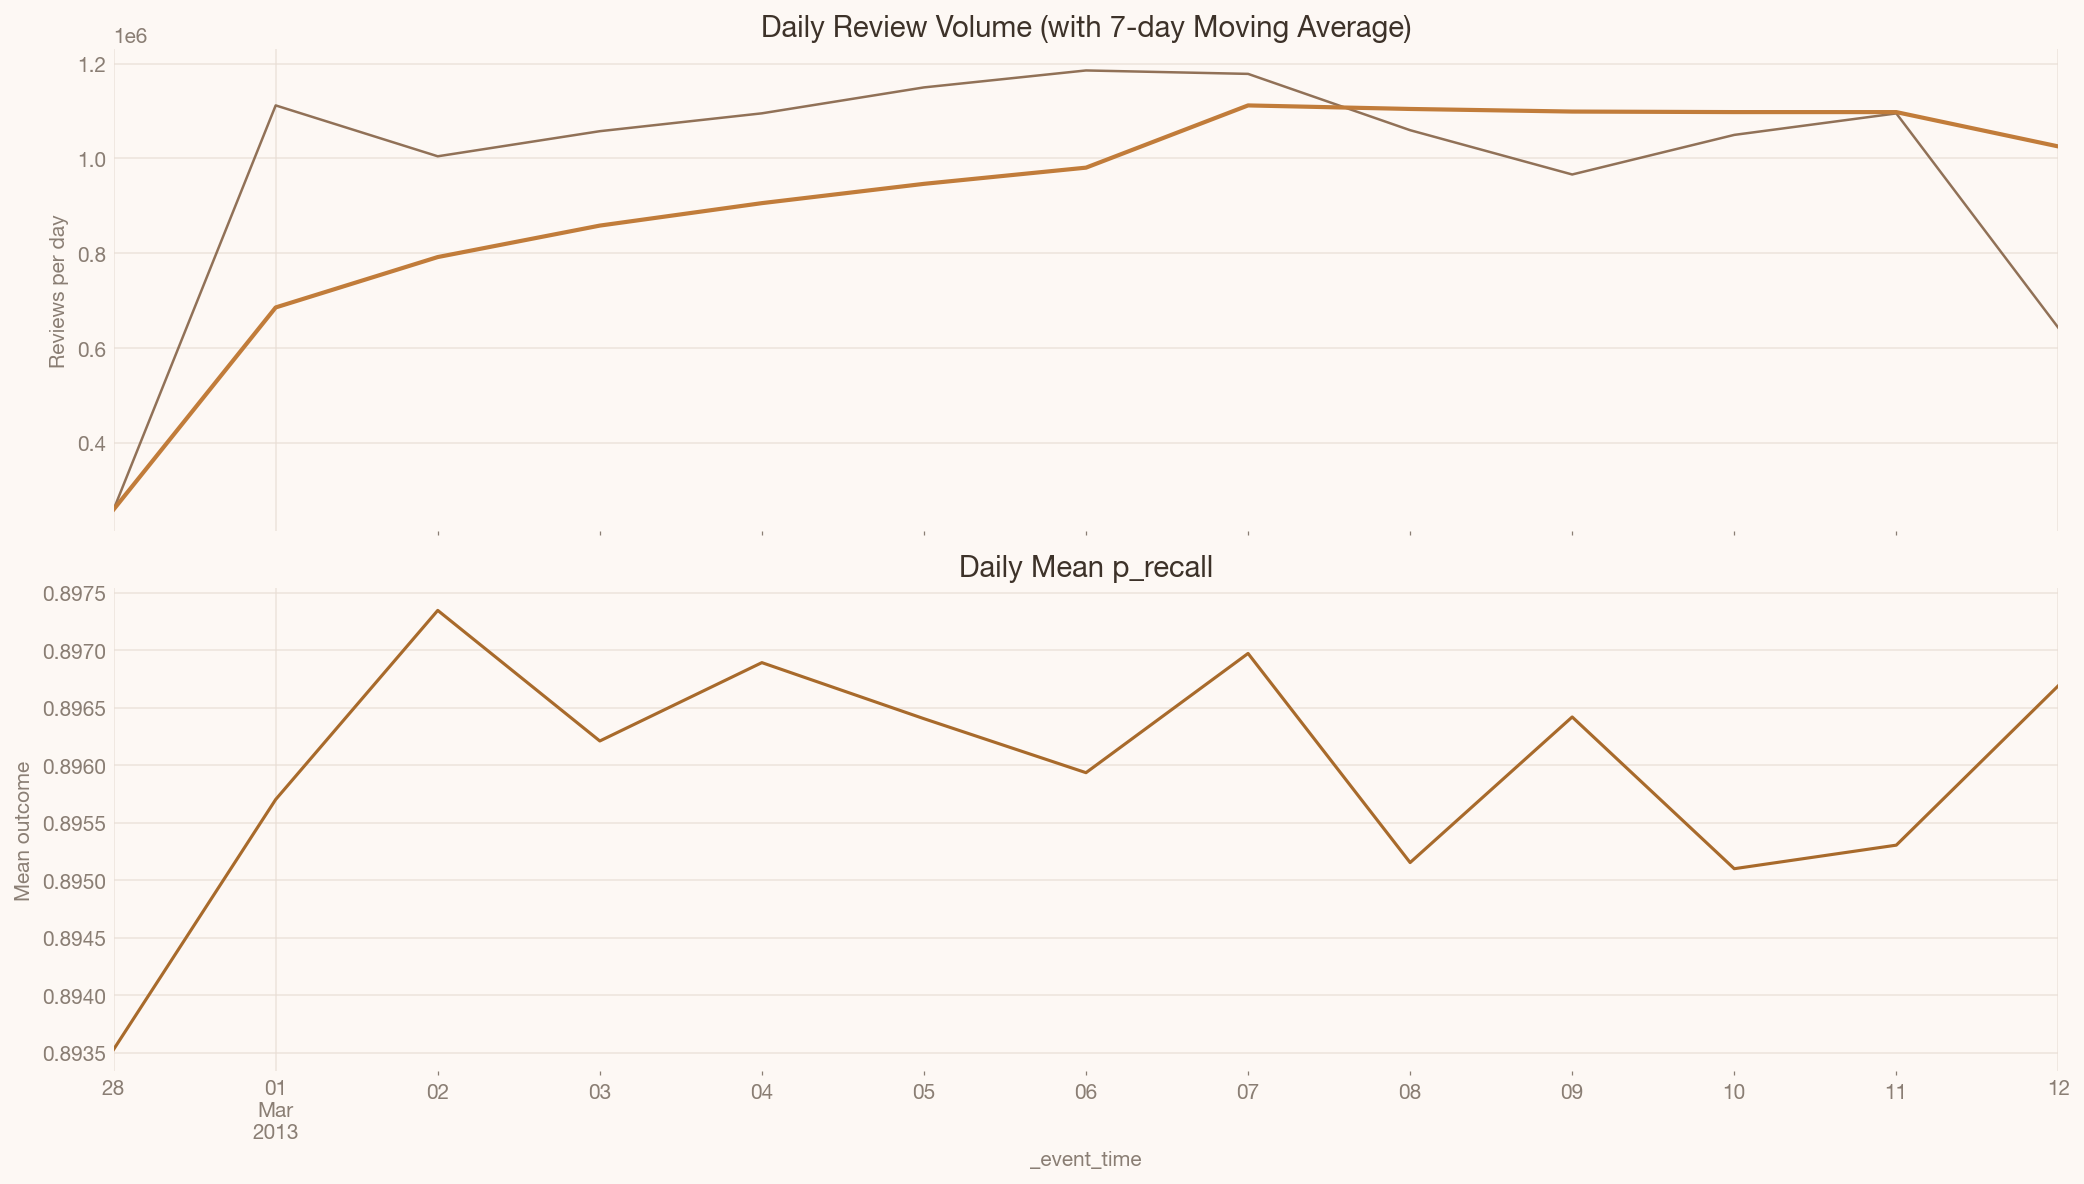

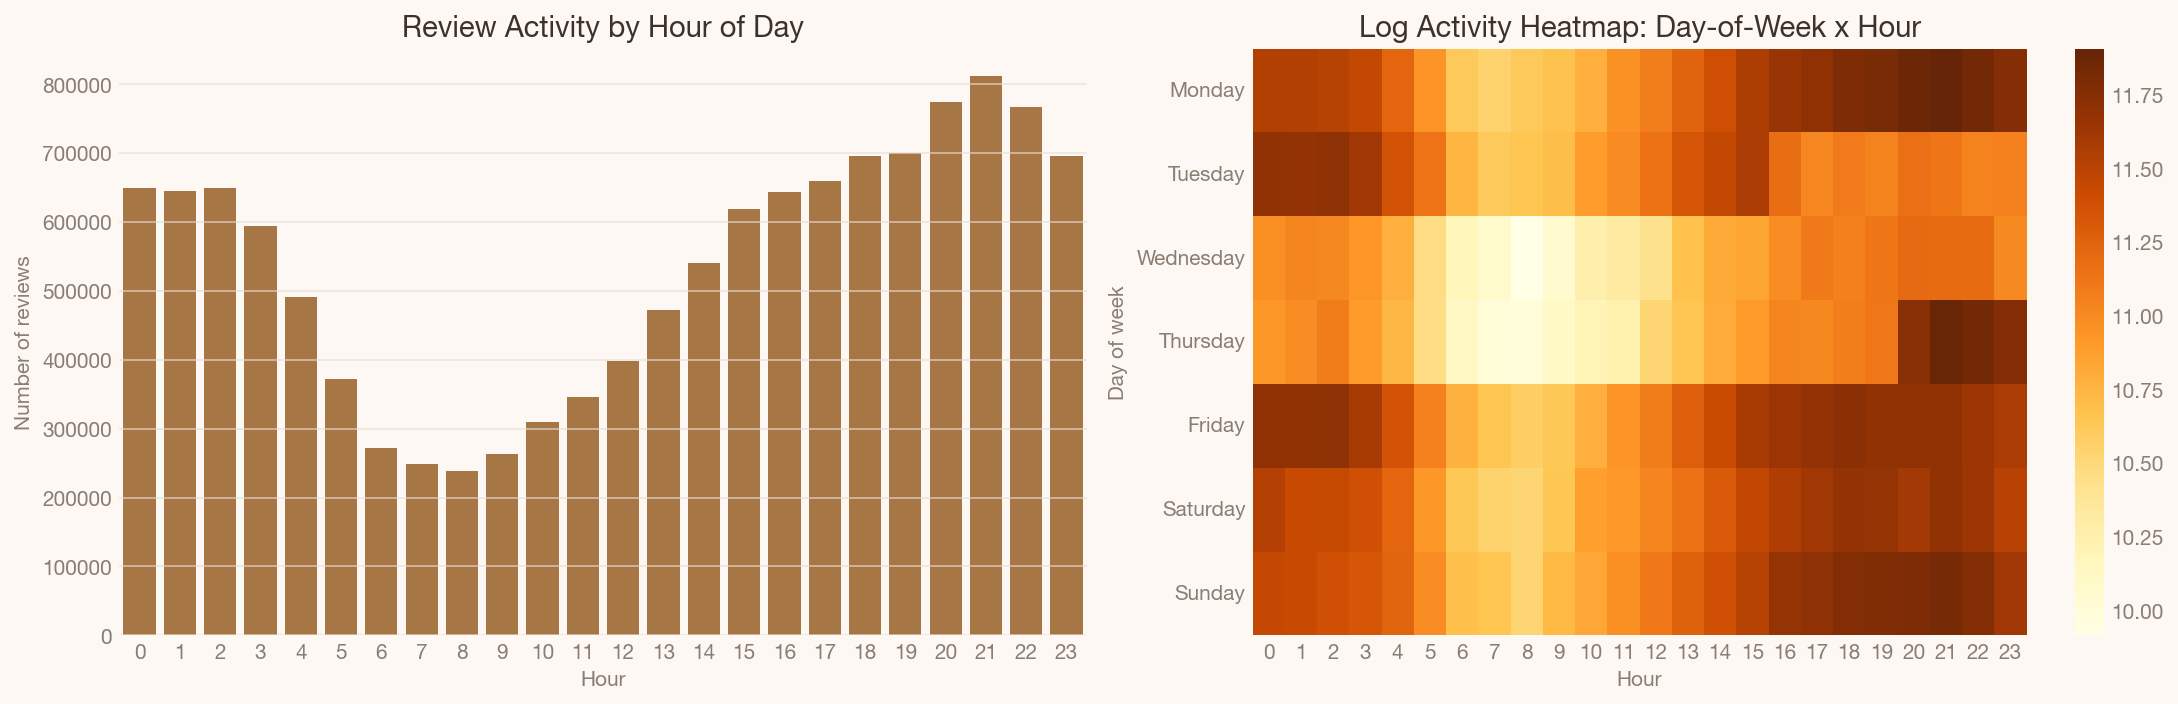

In [9]:
if "_event_time" not in df.columns or df["_event_time"].notna().sum() == 0:
    print("No usable timestamp column was found for temporal analysis.")
else:
    temporal_df = df.dropna(subset=["_event_time"]).copy()

    daily_counts = temporal_df.set_index("_event_time").resample("D").size().rename("n_reviews")
    daily_ma7 = daily_counts.rolling(7, min_periods=1).mean()

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    daily_counts.plot(ax=axes[0], color="#7E5A3C", linewidth=1.2, alpha=0.85)
    daily_ma7.plot(ax=axes[0], color="#C17C3A", linewidth=2)
    axes[0].set_title("Daily Review Volume (with 7-day Moving Average)")
    axes[0].set_ylabel("Reviews per day")

    if schema["prob_col"] is not None and schema["prob_col"] in temporal_df.columns:
        quality = pd.to_numeric(temporal_df[schema["prob_col"]], errors="coerce")
        daily_quality = quality.groupby(temporal_df["_event_time"].dt.floor("D")).mean()
        daily_quality.plot(ax=axes[1], color="#A86A2B", linewidth=1.5)
        axes[1].set_title(f"Daily Mean {schema['prob_col']}")
        axes[1].set_ylabel("Mean outcome")
    else:
        axes[1].text(0.5, 0.5, "No outcome column available for temporal quality trend.", ha="center", va="center")
        axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()

    hourly_profile = temporal_df["_event_time"].dt.hour.value_counts().sort_index()
    dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    dow_hour = (
        temporal_df.assign(_dow=temporal_df["_event_time"].dt.day_name(), _hour=temporal_df["_event_time"].dt.hour)
        .groupby(["_dow", "_hour"], observed=True)
        .size()
        .unstack(fill_value=0)
        .reindex(dow_order)
    )

    fig, axes = plt.subplots(1, 2, figsize=(15, 4.8))
    sns.barplot(x=hourly_profile.index, y=hourly_profile.values, ax=axes[0], color="#B67634")
    axes[0].set_title("Review Activity by Hour of Day")
    axes[0].set_xlabel("Hour")
    axes[0].set_ylabel("Number of reviews")

    sns.heatmap(np.log1p(dow_hour), cmap="YlOrBr", ax=axes[1])
    axes[1].set_title("Log Activity Heatmap: Day-of-Week x Hour")
    axes[1].set_xlabel("Hour")
    axes[1].set_ylabel("Day of week")

    plt.tight_layout()
    plt.show()


## User-Level Behavior
User heterogeneity is characterized through workload, temporal persistence, lexical breadth, and performance metrics. This is essential for modeling latent learner trajectories and stratifying interventions.


User-level summary statistics:


,count,mean,std,min,25%,50%,75%,90%,99%,max
n_reviews,115222.0,1.115605e+02,2.503088e+02,1.000000,10.000000,34.000000,112.00,2.800000e+02,1.065790e+03,19194.0
n_unique_items,115222.0,5.087248e+01,8.096386e+01,1.000000,9.000000,26.000000,60.00,1.210000e+02,3.717900e+02,3251.0
active_days,115222.0,3.223317e+00,3.267937e+00,1.000000,1.000000,1.000000,5.00,9.000000e+00,1.200000e+01,12.0
reviews_per_active_day,115222.0,3.426883e+01,5.237352e+01,0.166667,7.000000,18.000000,40.00,8.133333e+01,2.440000e+02,2503.0
mean_outcome,115222.0,8.936886e-01,9.270582e-02,0.000000,0.861111,0.909091,0.95,1.000000e+00,1.000000e+00,1.0
median_interval,115222.0,1.254528e+06,3.186123e+06,1.000000,3397.625000,175203.250000,920140.50,3.135352e+06,1.874959e+07,39758311.0


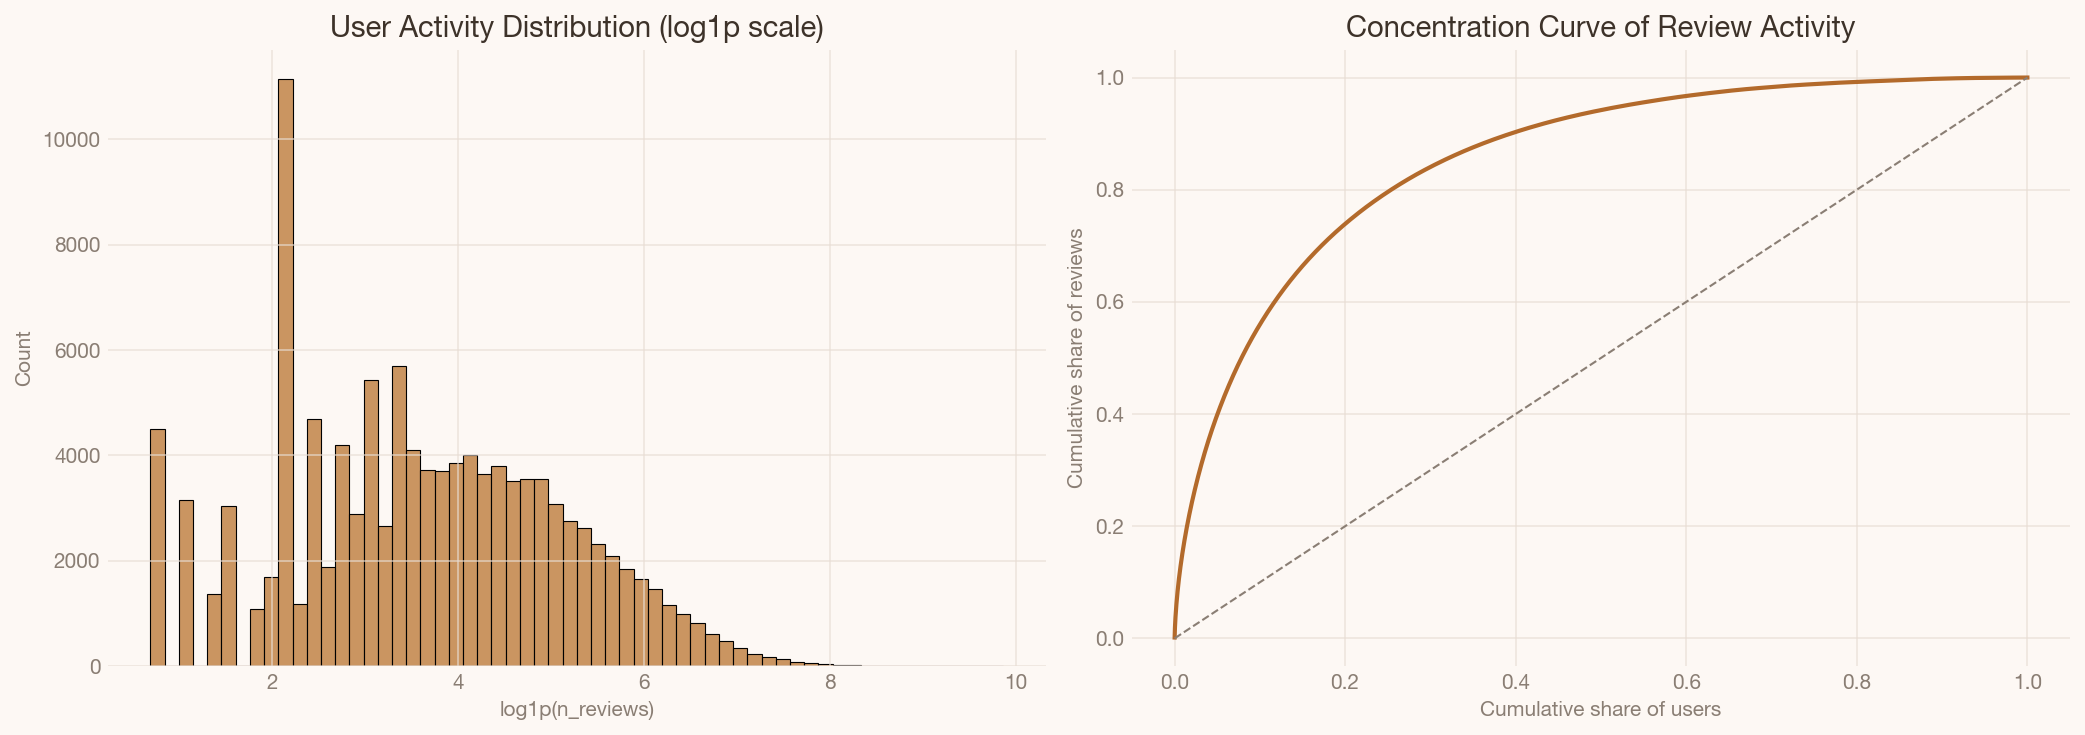

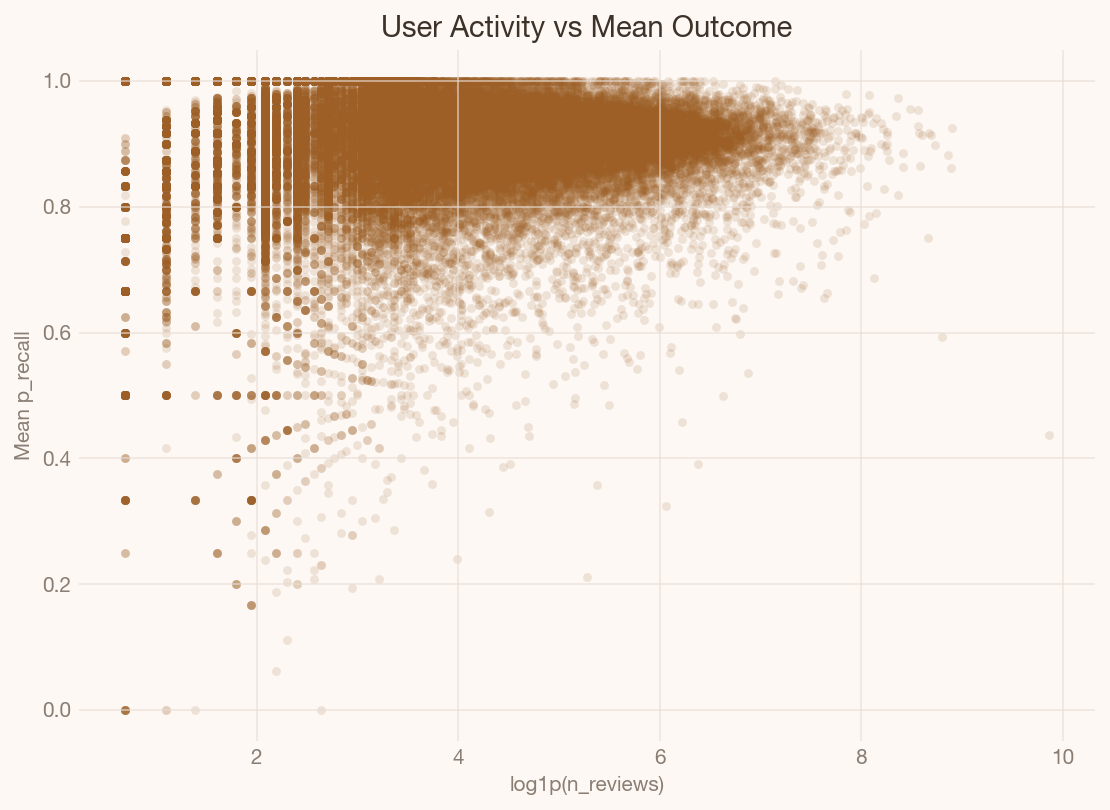

In [10]:
user_col = schema["user_col"]
item_col = schema["item_col"]
prob_col = schema["prob_col"]
interval_col = schema["interval_col"]

if user_col is None or user_col not in df.columns:
    print("No user identifier column detected; skipping user-level analysis.")
else:
    grouped = df.groupby(user_col, dropna=False)
    user_stats = pd.DataFrame({"n_reviews": grouped.size()})

    if item_col is not None and item_col in df.columns:
        user_stats["n_unique_items"] = grouped[item_col].nunique()

    if "_event_time" in df.columns:
        user_stats["first_event"] = grouped["_event_time"].min()
        user_stats["last_event"] = grouped["_event_time"].max()
        user_stats["active_days"] = (user_stats["last_event"] - user_stats["first_event"]).dt.days + 1
        user_stats["reviews_per_active_day"] = user_stats["n_reviews"] / user_stats["active_days"].replace(0, np.nan)

    if prob_col is not None and prob_col in df.columns:
        user_stats["mean_outcome"] = pd.to_numeric(grouped[prob_col].mean(), errors="coerce")

    if interval_col is not None and interval_col in df.columns:
        user_stats["median_interval"] = pd.to_numeric(grouped[interval_col].median(), errors="coerce")

    print("User-level summary statistics:")
    display(user_stats.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]).T)

    activity = user_stats["n_reviews"].sort_values(ascending=False)
    cumulative_users = np.arange(1, len(activity) + 1) / len(activity)
    cumulative_reviews = activity.cumsum() / activity.sum()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(np.log1p(user_stats["n_reviews"]), bins=60, ax=axes[0], color="#BA7430")
    axes[0].set_title("User Activity Distribution (log1p scale)")
    axes[0].set_xlabel("log1p(n_reviews)")

    axes[1].plot(cumulative_users, cumulative_reviews, color="#B36A2B", linewidth=2)
    axes[1].plot([0, 1], [0, 1], linestyle="--", color="#8A7E74", linewidth=1)
    axes[1].set_title("Concentration Curve of Review Activity")
    axes[1].set_xlabel("Cumulative share of users")
    axes[1].set_ylabel("Cumulative share of reviews")

    plt.tight_layout()
    plt.show()

    if "mean_outcome" in user_stats.columns:
        scatter_df = user_stats.dropna(subset=["mean_outcome"]).copy()
        if len(scatter_df) > 50_000:
            scatter_df = scatter_df.sample(50_000, random_state=cfg.random_state)

        plt.figure(figsize=(7.5, 5.5))
        sns.scatterplot(
            data=scatter_df,
            x=np.log1p(scatter_df["n_reviews"]),
            y="mean_outcome",
            alpha=0.15,
            s=18,
            color="#9D5F25",
            linewidth=0,
        )
        plt.title("User Activity vs Mean Outcome")
        plt.xlabel("log1p(n_reviews)")
        plt.ylabel(f"Mean {prob_col}")
        plt.tight_layout()
        plt.show()


## Item-Level Behavior
Item-level diagnostics reveal lexical/content difficulty, exposure concentration, and cross-user consistency. This is critical for understanding curriculum bias and item calibration quality.


Item-level summary statistics:


,count,mean,std,min,25%,50%,75%,90%,99%,max
n_reviews,19279.0,6.667475e+02,3.366106e+03,1.0,5.000000,26.000000,176.00000,963.0,13757.08,123099.0
n_users,19279.0,3.040422e+02,1.236704e+03,1.0,3.000000,17.000000,104.00000,507.0,5927.76,28330.0
mean_outcome,19279.0,8.674411e-01,1.582685e-01,0.0,0.831042,0.901316,0.97459,1.0,1.00,1.0
median_interval,19279.0,1.040076e+06,2.819218e+06,1.0,84922.000000,205739.000000,601735.50000,2098368.4,15847444.59,31722585.0


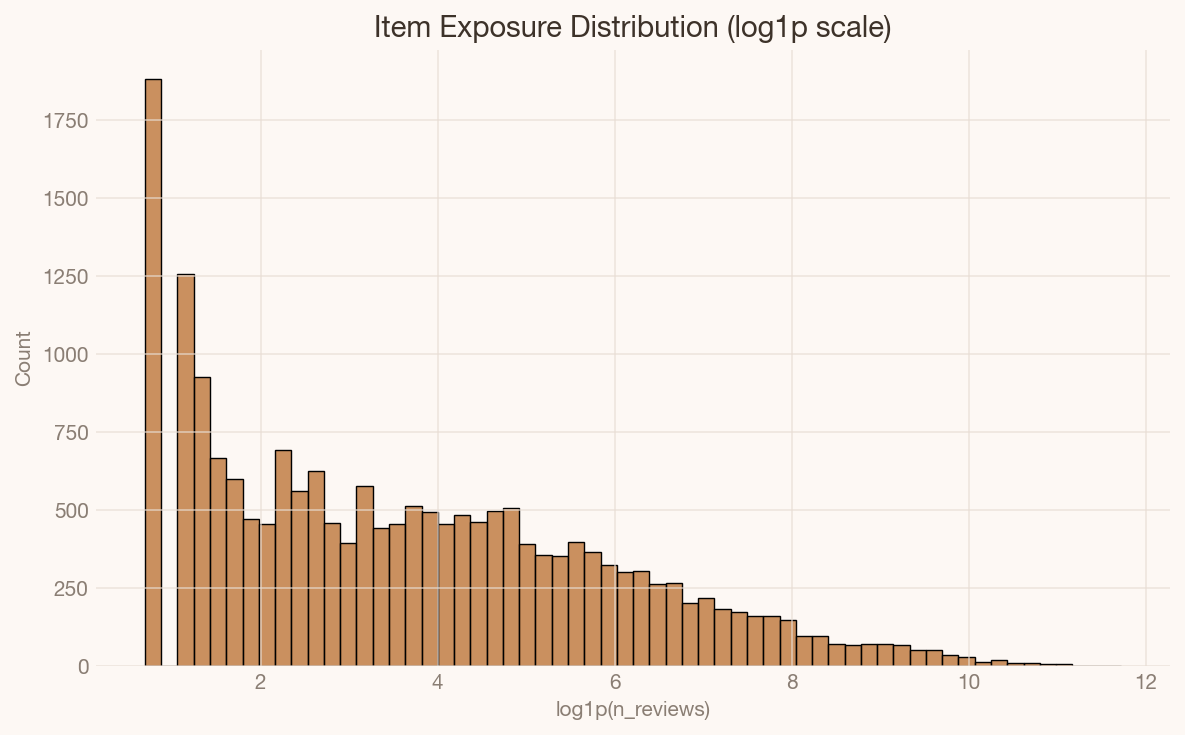

Top 20 difficult items (n_reviews >= 30):


,n_reviews,n_users,mean_outcome,median_interval,lexeme_string
lexeme_id,,,,,
2fc63c6d7f403d202de9e5686fc7a0fa,35,12,0.309524,111614.0,soeben/soeben<preadv>
aca51e7f937297b7bcc9fd9ad92949c3,32,15,0.309896,87938.0,inzwischen/inzwischen<adv>
4ff50df95fd18c28e3fcdd55ce422a3b,60,18,0.416667,83485.5,more/more<n><sg>
43bb11841b9a59d6ac79cce3fb2fea45,33,16,0.439394,169870.0,as/avoir<vbhaver><pri><p2><sg><@compound_past>
bd69444b59317aa42c375ccf85c6fda9,30,10,0.450794,118356.5,hat/haben<vbhaver><pri><p3><sg><@present_perfe...
c36ac14f7ae81cfe5752c0752cfebe75,35,15,0.453741,31374.0,vorne/vorne<adv>
b0ee4213a830d6322c4cad8e10c61a4f,110,13,0.459004,858.0,since/since<pr>
f0ce978a766eed9c7c8d0b5e2caf3590,37,17,0.472973,114253.0,eben/eben<adv>
fa6ab0bf13f198af97838c52832b3480,33,15,0.484848,171826.0,hinzu/hinzu<adv>


In [11]:
item_col = schema["item_col"]
user_col = schema["user_col"]
prob_col = schema["prob_col"]
interval_col = schema["interval_col"]

if item_col is None or item_col not in df.columns:
    print("No item identifier column detected; skipping item-level analysis.")
else:
    item_grouped = df.groupby(item_col, dropna=False)
    item_stats = pd.DataFrame({"n_reviews": item_grouped.size()})

    if user_col is not None and user_col in df.columns:
        item_stats["n_users"] = item_grouped[user_col].nunique()

    if prob_col is not None and prob_col in df.columns:
        item_stats["mean_outcome"] = pd.to_numeric(item_grouped[prob_col].mean(), errors="coerce")

    if interval_col is not None and interval_col in df.columns:
        item_stats["median_interval"] = pd.to_numeric(item_grouped[interval_col].median(), errors="coerce")

    print("Item-level summary statistics:")
    display(item_stats.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]).T)

    plt.figure(figsize=(8, 5))
    sns.histplot(np.log1p(item_stats["n_reviews"]), bins=60, color="#B96D2D")
    plt.title("Item Exposure Distribution (log1p scale)")
    plt.xlabel("log1p(n_reviews)")
    plt.tight_layout()
    plt.show()

    if "mean_outcome" in item_stats.columns:
        difficult_items = item_stats[item_stats["n_reviews"] >= cfg.min_group_size].sort_values("mean_outcome").head(20)

        if "lexeme_string" in df.columns:
            label_map = (
                df[[item_col, "lexeme_string"]]
                .dropna()
                .drop_duplicates(subset=[item_col])
                .set_index(item_col)["lexeme_string"]
            )
            difficult_items = difficult_items.join(label_map, how="left")

        print(f"Top 20 difficult items (n_reviews >= {cfg.min_group_size}):")
        display(difficult_items)


## Correlations and Notable Interactions
The final section quantifies monotonic relationships among numeric variables and evaluates domain-relevant interactions such as spacing interval vs recall probability.


Top correlation pairs by absolute Spearman coefficient:


,,spearman_r,abs_r
delta,log_interval,1.000000,1.000000
p_recall,session_acc,1.000000,1.000000
history_seen,history_correct,0.984541,0.984541
session_seen,session_correct,0.908961,0.908961
history_seen,history_acc,-0.303220,0.303220
p_recall,session_correct,0.252620,0.252620
session_correct,session_acc,0.252620,0.252620
delta,history_seen,-0.210529,0.210529
history_seen,log_interval,-0.210529,0.210529
history_correct,log_interval,-0.206210,0.206210


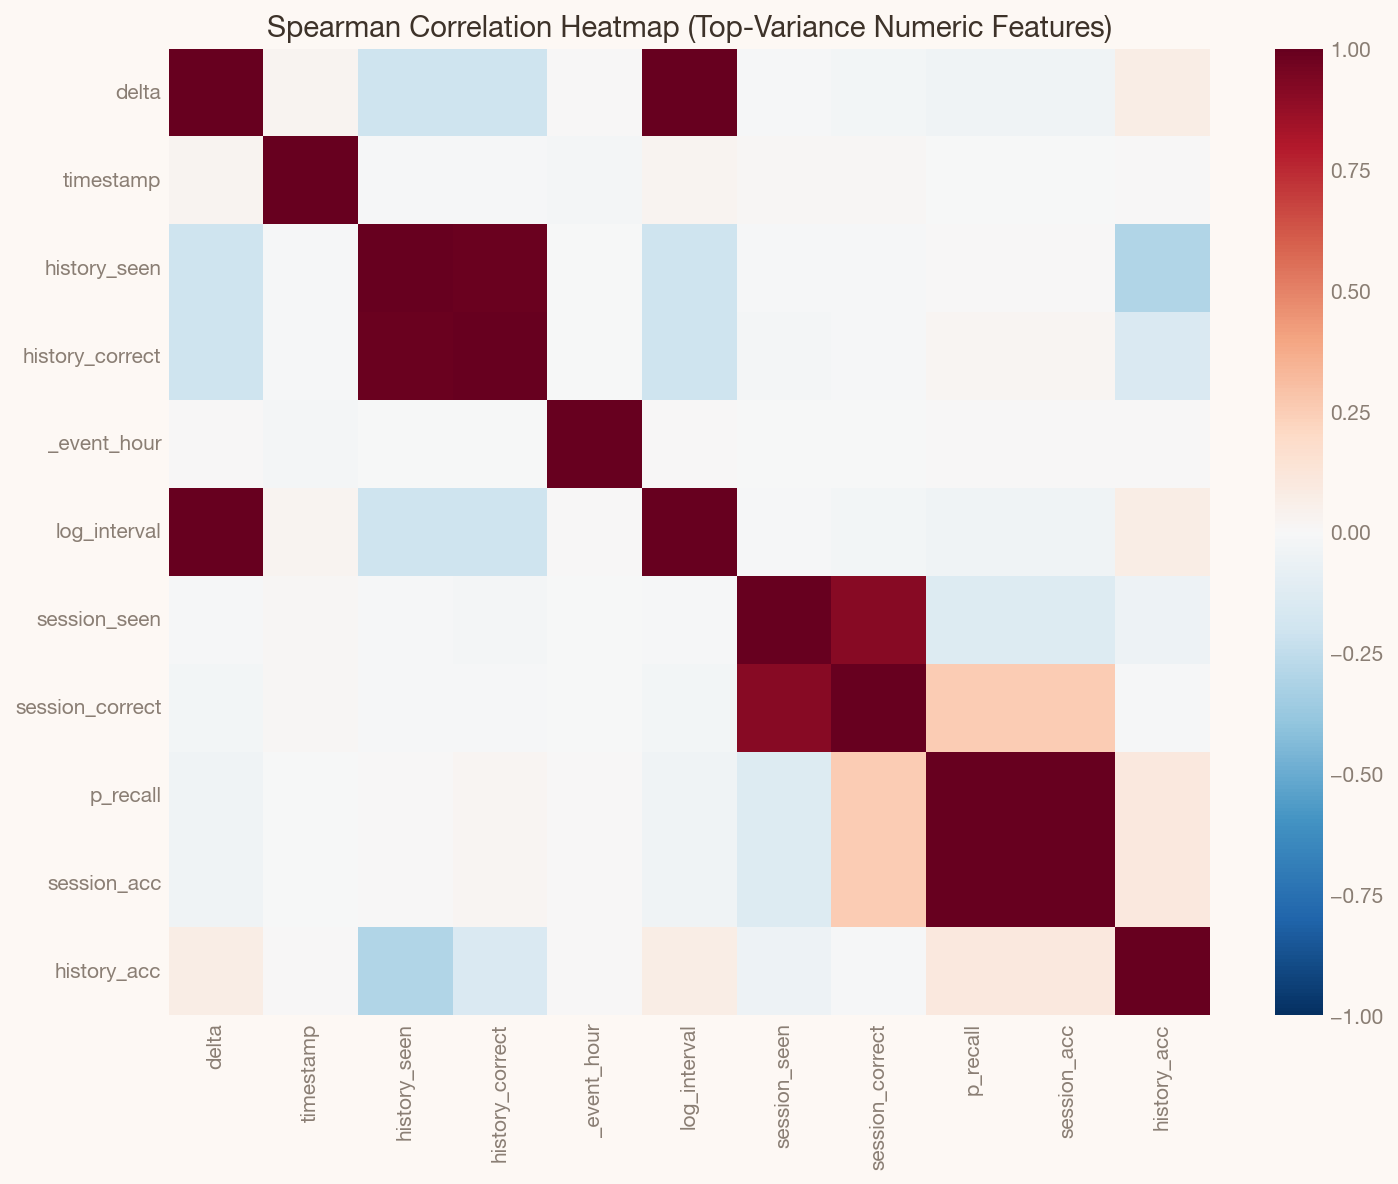

Interval vs outcome (quantile-binned):


,n,mean_outcome,median_interval
0,1066247,0.895317,147.0
1,1062194,0.922453,246.0
2,1056092,0.916657,395.0
3,1057969,0.909818,737.0
4,1059897,0.901266,2382.0
5,1060443,0.895009,41066.0
6,1060473,0.893697,88071.0
7,1060495,0.891302,173312.0
8,1060465,0.889384,328732.0
9,1060463,0.887012,586206.0


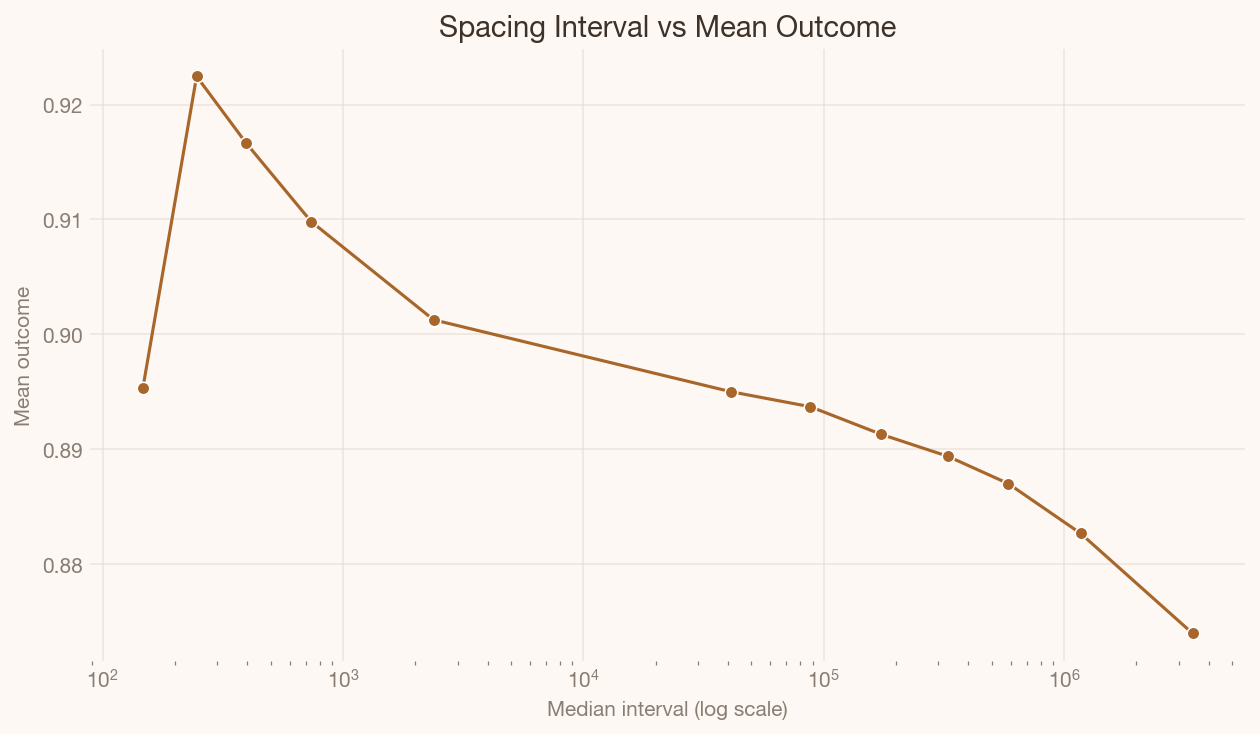

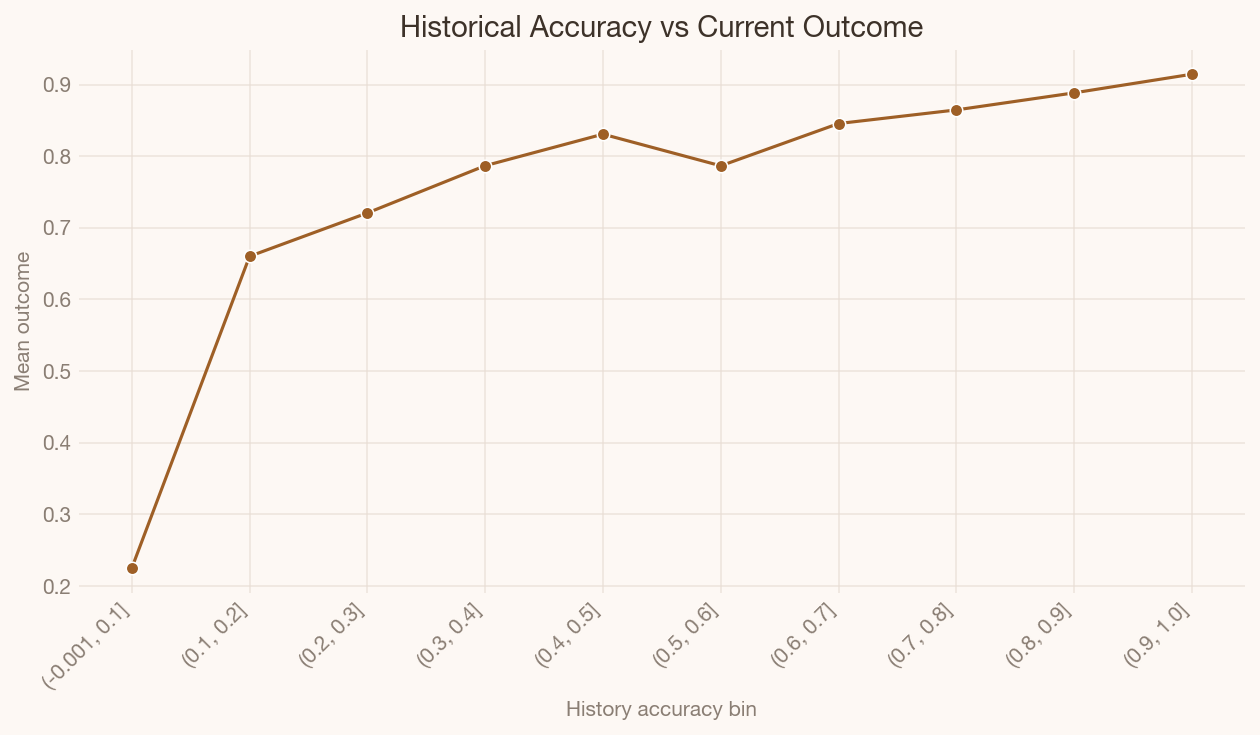

In [12]:
numeric_analysis = df.select_dtypes(include=[np.number]).copy()

if numeric_analysis.shape[1] < 2:
    print("Insufficient numeric columns for correlation analysis.")
else:
    corr = numeric_analysis.corr(method="spearman")

    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    strongest_pairs = (
        upper.stack()
        .rename("spearman_r")
        .to_frame()
        .assign(abs_r=lambda x: x["spearman_r"].abs())
        .sort_values("abs_r", ascending=False)
    )

    print("Top correlation pairs by absolute Spearman coefficient:")
    display(strongest_pairs.head(20))

    heatmap_cols = numeric_analysis.var().sort_values(ascending=False).head(12).index.tolist()
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        numeric_analysis[heatmap_cols].corr(method="spearman"),
        cmap="RdBu_r",
        center=0,
        vmin=-1,
        vmax=1,
        annot=False,
    )
    plt.title("Spearman Correlation Heatmap (Top-Variance Numeric Features)")
    plt.tight_layout()
    plt.show()

if schema["interval_col"] is not None and schema["prob_col"] is not None:
    interaction = df[[schema["interval_col"], schema["prob_col"]]].copy()
    interaction.columns = ["interval", "outcome"]

    interaction["interval"] = pd.to_numeric(interaction["interval"], errors="coerce")
    interaction["outcome"] = pd.to_numeric(interaction["outcome"], errors="coerce")
    interaction = interaction.dropna()
    interaction = interaction[(interaction["interval"] >= 0)]

    if not interaction.empty:
        upper_cap = interaction["interval"].quantile(0.99)
        interaction = interaction[interaction["interval"] <= upper_cap]

        n_bins = int(min(12, interaction["interval"].nunique()))
        if n_bins >= 3:
            interaction["interval_bin"] = pd.qcut(interaction["interval"], q=n_bins, duplicates="drop")
            interval_effect = (
                interaction.groupby("interval_bin", observed=True)
                .agg(n=("outcome", "size"), mean_outcome=("outcome", "mean"), median_interval=("interval", "median"))
                .reset_index(drop=True)
            )

            print("Interval vs outcome (quantile-binned):")
            display(interval_effect)

            plt.figure(figsize=(8.5, 5))
            sns.lineplot(data=interval_effect, x="median_interval", y="mean_outcome", marker="o", color="#A8662A")
            plt.xscale("log")
            plt.title("Spacing Interval vs Mean Outcome")
            plt.xlabel("Median interval (log scale)")
            plt.ylabel("Mean outcome")
            plt.tight_layout()
            plt.show()

if "history_acc" in df.columns and schema["prob_col"] is not None:
    acc_df = df[["history_acc", schema["prob_col"]]].copy()
    acc_df.columns = ["history_acc", "outcome"]
    acc_df["history_acc"] = pd.to_numeric(acc_df["history_acc"], errors="coerce")
    acc_df["outcome"] = pd.to_numeric(acc_df["outcome"], errors="coerce")
    acc_df = acc_df.dropna()
    acc_df = acc_df[(acc_df["history_acc"] >= 0) & (acc_df["history_acc"] <= 1)]

    if not acc_df.empty:
        acc_df["acc_bin"] = pd.cut(acc_df["history_acc"], bins=np.linspace(0, 1, 11), include_lowest=True)
        acc_effect = (
            acc_df.groupby("acc_bin", observed=True)
            .agg(n=("outcome", "size"), mean_outcome=("outcome", "mean"))
            .reset_index()
        )
        acc_effect["acc_bin_label"] = acc_effect["acc_bin"].astype(str)

        plt.figure(figsize=(8.5, 5))
        sns.lineplot(data=acc_effect, x="acc_bin_label", y="mean_outcome", marker="o", color="#9E5F26")
        plt.title("Historical Accuracy vs Current Outcome")
        plt.xlabel("History accuracy bin")
        plt.ylabel("Mean outcome")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


## Reproducibility Notes
- All random operations use `cfg.random_state`.
- Plot sample size is capped by `cfg.max_rows_for_plots` for stable performance.
- All key assumptions (schema inference and time parsing) are explicit in code and easy to audit.
